## 1. Import Libraries and Setup

In [175]:

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline



## 2. Load and Explore Data

In [169]:
df = pd.read_csv('uber-data.csv')

print("Dataset Shape:", df.shape)
print("First few rows:")
print(df.head(10))
print("Data Types:")
print(df.dtypes)
print("Missing Values:")
print(df.isnull().sum())
print("Basic Statistics:")
print(df.describe())

Dataset Shape: (1028136, 4)
First few rows:
          Date/Time      Lat      Lon    Base
0  9/1/2014 0:01:00  40.2201 -74.0021  B02512
1  9/1/2014 0:01:00  40.7500 -74.0027  B02512
2  9/1/2014 0:03:00  40.7559 -73.9864  B02512
3  9/1/2014 0:06:00  40.7450 -73.9889  B02512
4  9/1/2014 0:11:00  40.8145 -73.9444  B02512
5  9/1/2014 0:12:00  40.6735 -73.9918  B02512
6  9/1/2014 0:15:00  40.7471 -73.6472  B02512
7  9/1/2014 0:16:00  40.6613 -74.2691  B02512
8  9/1/2014 0:32:00  40.3745 -73.9999  B02512
9  9/1/2014 0:33:00  40.7633 -73.9773  B02512
Data Types:
Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object
Missing Values:
Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64
Basic Statistics:
                Lat           Lon
count  1.028136e+06  1.028136e+06
mean   4.073922e+01 -7.397182e+01
std    4.082861e-02  5.831413e-02
min    3.998970e+01 -7.477360e+01
25%    4.072040e+01 -7.399620e+01
50%    4.074180e+01 -7.398310

In [170]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date'] = df['Date/Time'].dt.date
df['Hour'] = df['Date/Time'].dt.hour
df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
df['DayOfWeekName'] = df['Date/Time'].dt.day_name()
df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day

print("\nUpdated DataFrame:")
print(df.head())


Updated DataFrame:
            Date/Time      Lat      Lon    Base        Date  Hour  DayOfWeek  \
0 2014-09-01 00:01:00  40.2201 -74.0021  B02512  2014-09-01     0          0   
1 2014-09-01 00:01:00  40.7500 -74.0027  B02512  2014-09-01     0          0   
2 2014-09-01 00:03:00  40.7559 -73.9864  B02512  2014-09-01     0          0   
3 2014-09-01 00:06:00  40.7450 -73.9889  B02512  2014-09-01     0          0   
4 2014-09-01 00:11:00  40.8145 -73.9444  B02512  2014-09-01     0          0   

  DayOfWeekName  Month  Day  
0        Monday      9    1  
1        Monday      9    1  
2        Monday      9    1  
3        Monday      9    1  
4        Monday      9    1  


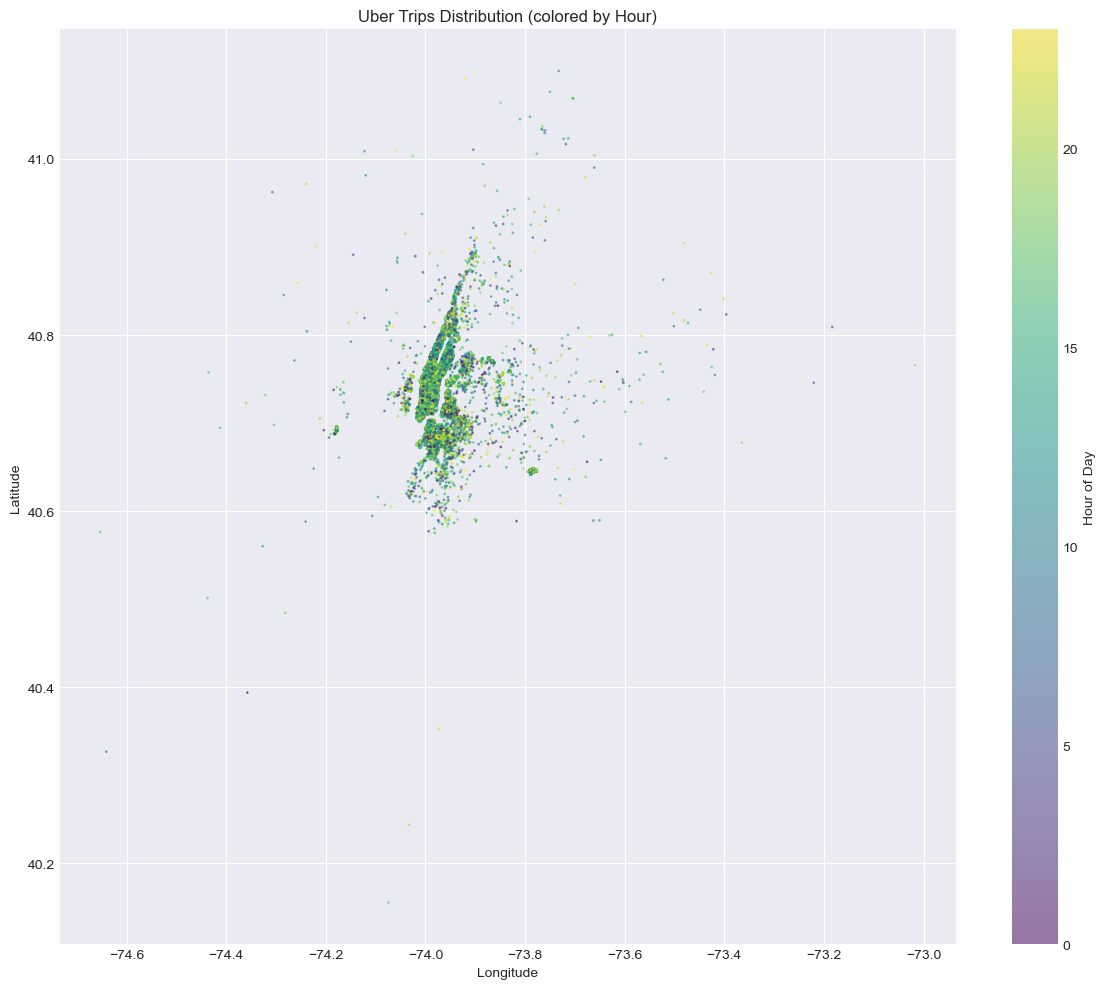

In [155]:
fig = px.scatter_mapbox(df.sample(10000), 
                        lat='Lat', 
                        lon='Lon',
                        hover_data=['Date/Time', 'Base'],
                        zoom=9,
                        height=600,
                        title='Uber Trips Distribution (Sample of 10,000 trips)')
fig.update_layout(mapbox_style="open-street-map")
fig.show()

fig, ax = plt.subplots(figsize=(12, 10))
sample_df = df.sample(20000)
scatter = ax.scatter(sample_df['Lon'], sample_df['Lat'], 
                     c=sample_df['Hour'], 
                     cmap='viridis', 
                     alpha=0.5, 
                     s=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Uber Trips Distribution (colored by Hour)')
plt.colorbar(scatter, label='Hour of Day')
plt.tight_layout()
plt.show()

## 3. Data Preparation for Clustering

We are going to use a sample to calculate k (with whole dataset it takes ages)

In [156]:
sample_size = 100000  
np.random.seed(42)
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

X = df_sample[['Lat', 'Lon']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Sample size: {len(df_sample):,} trips")
print(f"Feature shape: {X_scaled.shape}")
print(f"\nCoordinate ranges:")
print(f"Latitude: [{df_sample['Lat'].min():.4f}, {df_sample['Lat'].max():.4f}]")
print(f"Longitude: [{df_sample['Lon'].min():.4f}, {df_sample['Lon'].max():.4f}]")

Sample size: 100,000 trips
Feature shape: (100000, 2)

Coordinate ranges:
Latitude: [40.1248, 41.2759]
Longitude: [-74.6659, -72.7558]


## 4. Determine Optimal Number of Clusters

### 4.1 Elbow Method & Silhouette Analysis for K-Means

In [157]:
k_range = range(2, 10)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, DB={davies_bouldin_scores[-1]:.3f}, CH={calinski_harabasz_scores[-1]:.3f}")

Testing different numbers of clusters...
k=2: Silhouette=0.648, DB=0.931, CH=39017.858
k=3: Silhouette=0.402, DB=0.790, CH=50149.065
k=4: Silhouette=0.410, DB=0.845, CH=48621.189
k=5: Silhouette=0.436, DB=0.735, CH=48312.719
k=6: Silhouette=0.440, DB=0.760, CH=52690.212
k=7: Silhouette=0.461, DB=0.665, CH=56408.944
k=8: Silhouette=0.464, DB=0.649, CH=59107.217
k=9: Silhouette=0.419, DB=0.677, CH=60677.810


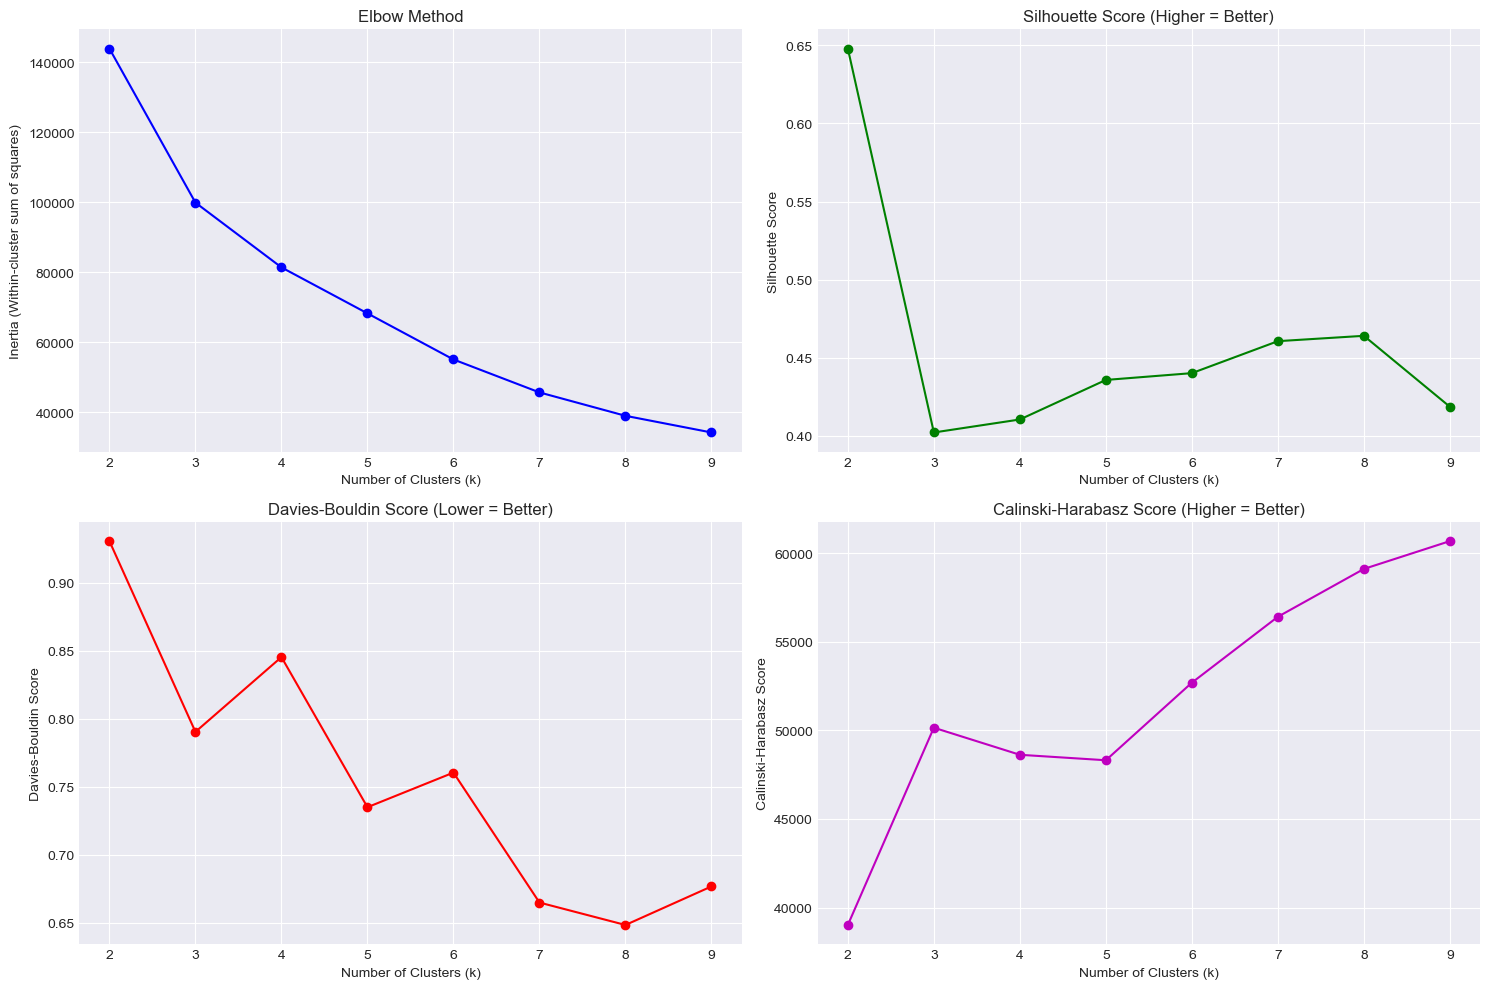

In [158]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# Silhouette score (higher is better)
axes[0, 1].plot(k_range, silhouette_scores, 'go-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher = Better)')
axes[0, 1].grid(True)

# Davies-Bouldin score (lower is better)
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].set_title('Davies-Bouldin Score (Lower = Better)')
axes[1, 0].grid(True)

# Calinski-Harabasz score (higher is better)
axes[1, 1].plot(k_range, calinski_harabasz_scores, 'mo-')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher = Better)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()



In [159]:
# Based on plotted metrics, we choose k = 8

optimal_k = 8
print(f"Let k={optimal_k} be the optimal number of clusters.")

Let k=8 be the optimal number of clusters.


## 5. Apply KMeans and DBSCAN


### 5.1 K-Means Clustering

We are going to make our sample bigger (I've tried with whole dataset and I waited for 1 hour and it didn't manage to finish)

In [160]:
sample_size = 400000  
np.random.seed(42)
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

X = df_sample[['Lat', 'Lon']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Sample size: {len(df_sample):,} trips")
print(f"Feature shape: {X_scaled.shape}")
print(f"\nCoordinate ranges:")
print(f"Latitude: [{df_sample['Lat'].min():.4f}, {df_sample['Lat'].max():.4f}]")
print(f"Longitude: [{df_sample['Lon'].min():.4f}, {df_sample['Lon'].max():.4f}]")

Sample size: 400,000 trips
Feature shape: (400000, 2)

Coordinate ranges:
Latitude: [40.0580, 41.3043]
Longitude: [-74.7155, -72.7339]


In [161]:

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_sample['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Get cluster centers in original scale
kmeans_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Evaluation
kmeans_silhouette = silhouette_score(X_scaled, df_sample['KMeans_Cluster'])
kmeans_db = davies_bouldin_score(X_scaled, df_sample['KMeans_Cluster'])
kmeans_ch = calinski_harabasz_score(X_scaled, df_sample['KMeans_Cluster'])

print(f"K-Means Clustering")
print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Score: {kmeans_db:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_ch:.4f}")
print(f"\nCluster sizes:")
print(df_sample['KMeans_Cluster'].value_counts().sort_index())

K-Means Clustering
Number of clusters: 8
Silhouette Score: 0.4629
Davies-Bouldin Score: 0.6490
Calinski-Harabasz Score: 237801.1710

Cluster sizes:
KMeans_Cluster
0    141489
1    176669
2     11004
3     41524
4      3909
5      7240
6      1143
7     17022
Name: count, dtype: int64


## 6. Visualize Clustering Results

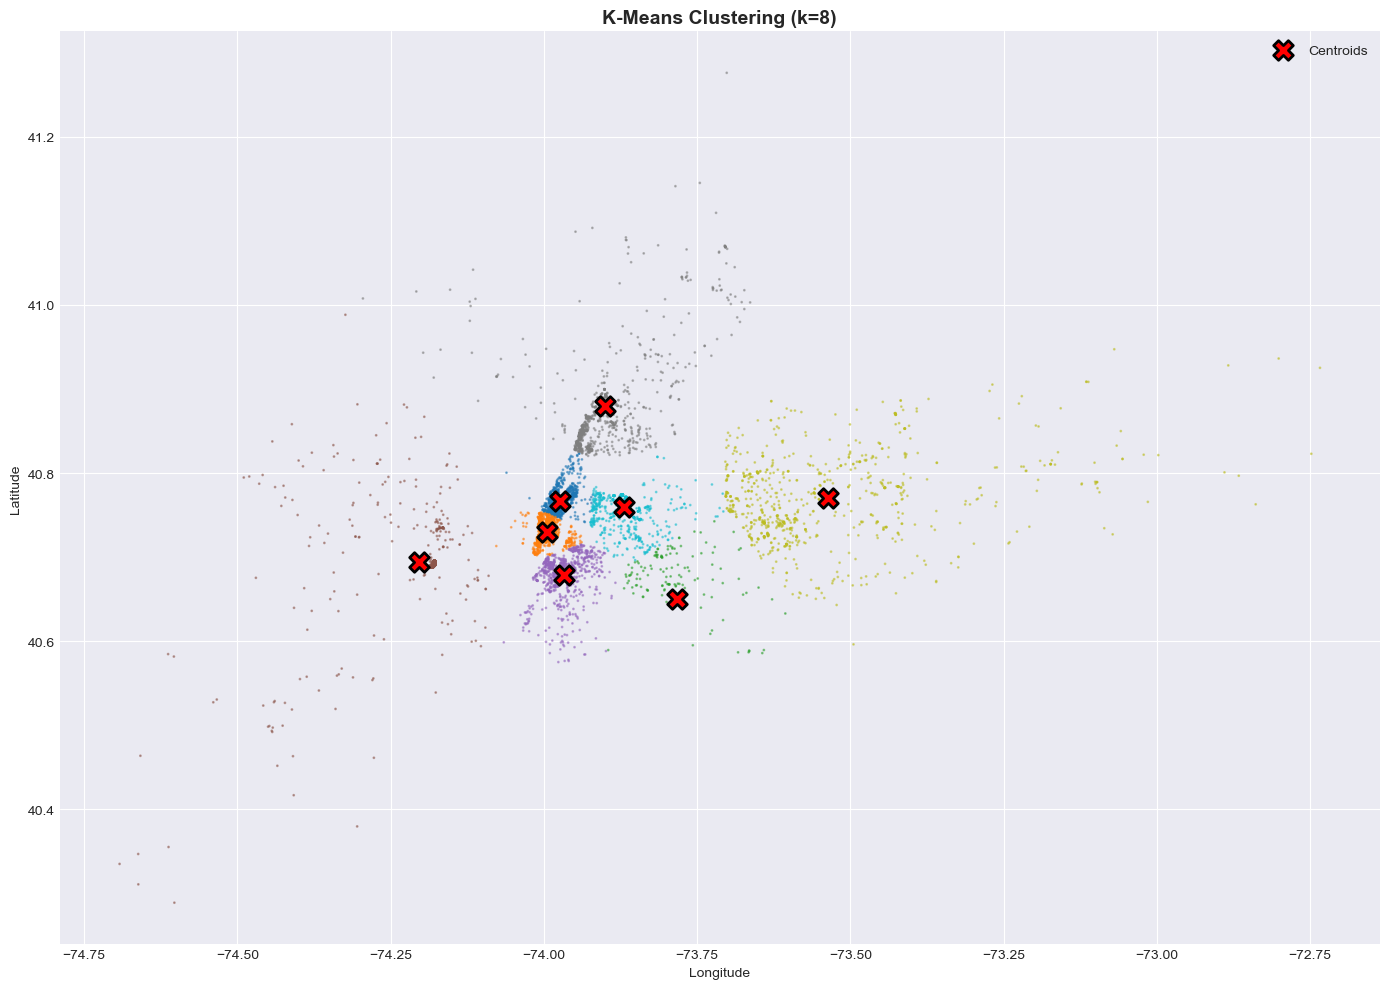

In [185]:
sample_for_static_viz = df_sample.groupby('KMeans_Cluster', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 800), random_state=42)
)

fig, axes = plt.subplots(1, 1, figsize=(14, 10))

axes.scatter(sample_for_static_viz['Lon'], sample_for_static_viz['Lat'], 
            c=sample_for_static_viz['KMeans_Cluster'], cmap='tab10', alpha=0.5, s=1)
axes.scatter(kmeans_centers[:, 1], kmeans_centers[:, 0], 
            c='red', marker='X', s=200, edgecolors='black', linewidths=2, label='Centroids')
axes.set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
axes.legend()

plt.tight_layout()
plt.show()

In [201]:
sample_for_viz = df_sample.groupby('KMeans_Cluster', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 800), random_state=42)
)

fig = px.scatter_mapbox(sample_for_viz, 
                        lat='Lat', 
                        lon='Lon',
                        color='KMeans_Cluster',
                        hover_data=['Hour', 'DayOfWeekName'],
                        zoom=9,
                        height=700,
                        title=f'K-Means Clustering Results - Interactive Map (k={optimal_k})',
                        color_continuous_scale='Viridis')
fig.update_layout(mapbox_style="open-street-map")


fig.write_html("kmeans_map.html")

fig.show()

## 7. Analyze Cluster Centers by Time



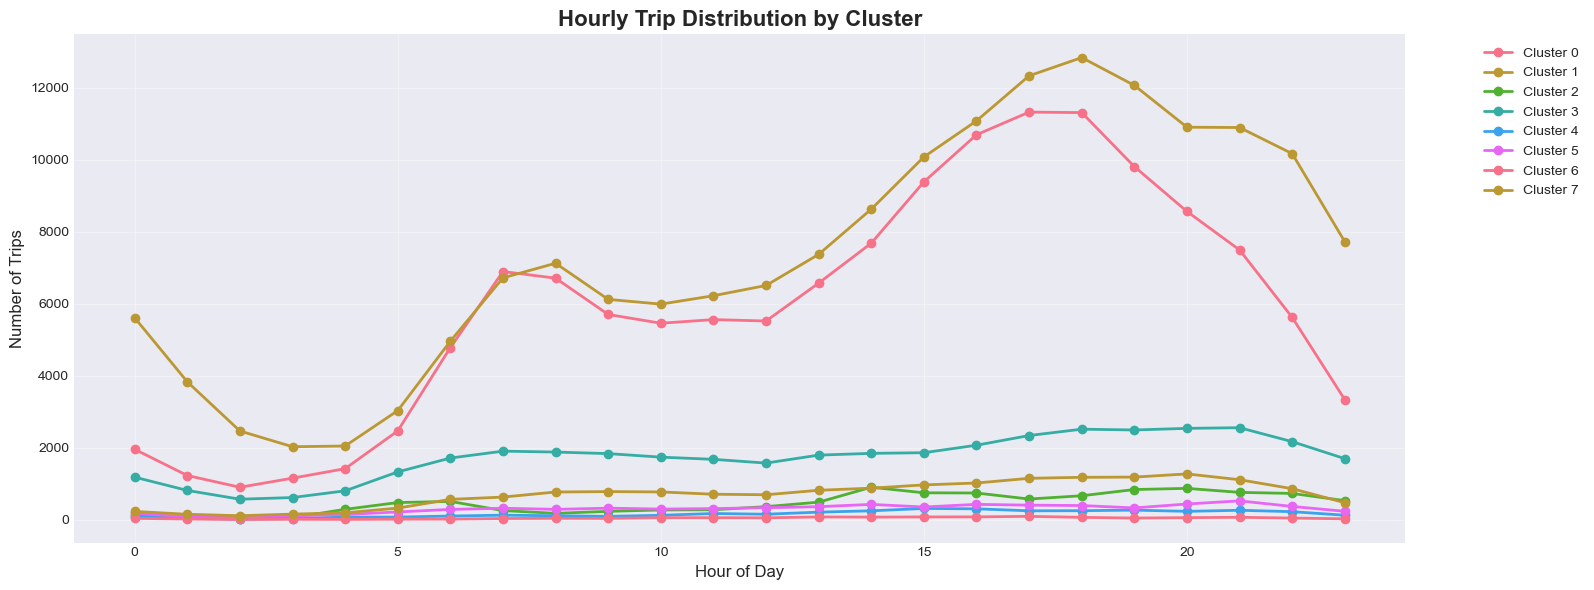

In [164]:
hourly_clusters = df_sample.groupby(['KMeans_Cluster', 'Hour']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(16, 6))
for cluster in sorted(df_sample['KMeans_Cluster'].unique()):
    cluster_data = hourly_clusters[hourly_clusters['KMeans_Cluster'] == cluster]
    ax.plot(cluster_data['Hour'], cluster_data['Count'], marker='o', label=f'Cluster {cluster}', linewidth=2)

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
ax.set_title('Hourly Trip Distribution by Cluster', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Analyze Cluster Centers by Date



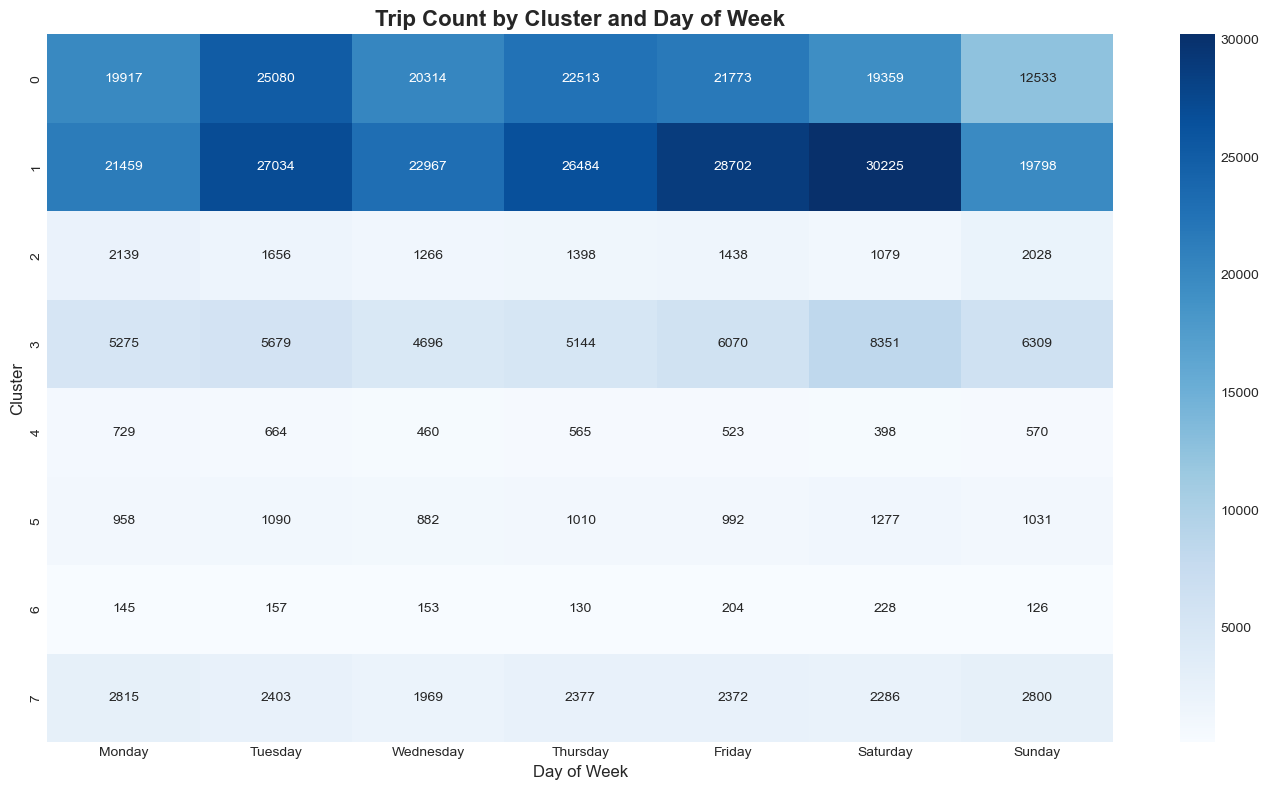

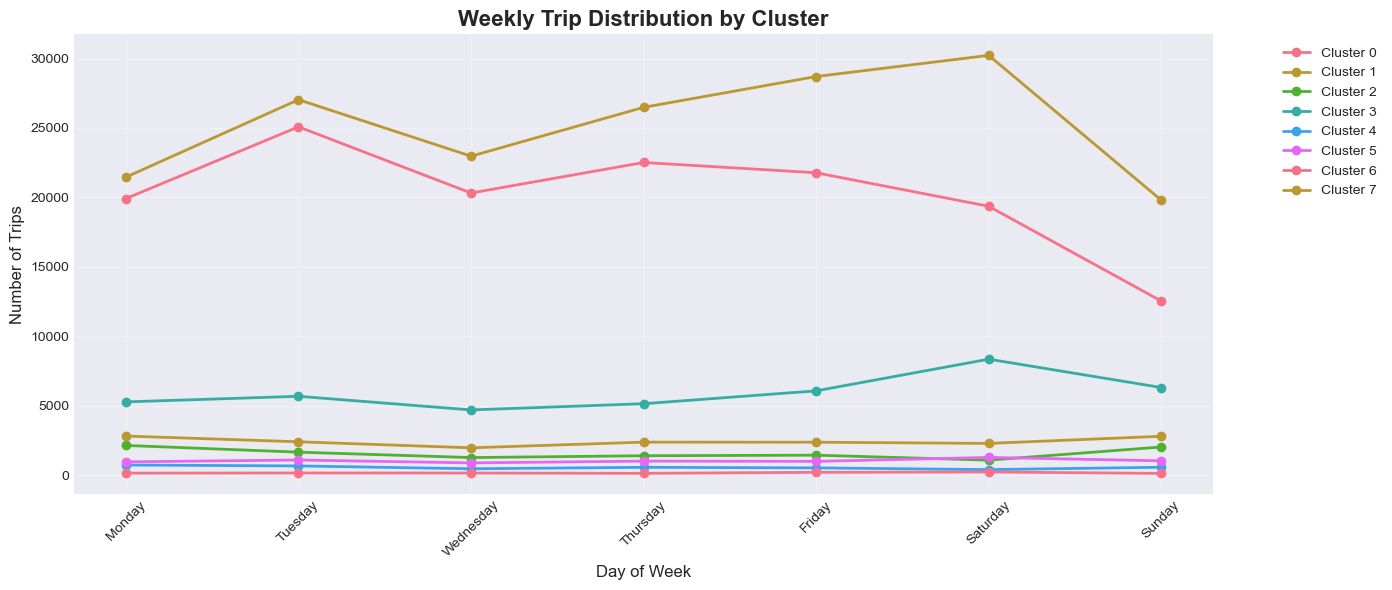

In [165]:
dow_clusters = df_sample.groupby(['KMeans_Cluster', 'DayOfWeek', 'DayOfWeekName']).size().reset_index(name='Count')

dow_pivot = dow_clusters.pivot(index='KMeans_Cluster', columns='DayOfWeekName', values='Count').fillna(0)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pivot = dow_pivot[[col for col in day_order if col in dow_pivot.columns]]

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(dow_pivot, annot=True, fmt='.0f', cmap='Blues', ax=ax)
ax.set_title('Trip Count by Cluster and Day of Week', fontsize=16, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
plt.tight_layout()
plt.show()

# Line plot
fig, ax = plt.subplots(figsize=(14, 6))
for cluster in sorted(df_sample['KMeans_Cluster'].unique()):
    cluster_data = dow_clusters[dow_clusters['KMeans_Cluster'] == cluster].sort_values('DayOfWeek')
    ax.plot(cluster_data['DayOfWeekName'], cluster_data['Count'], marker='o', 
            label=f'Cluster {cluster}', linewidth=2)

ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
ax.set_title('Weekly Trip Distribution by Cluster', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

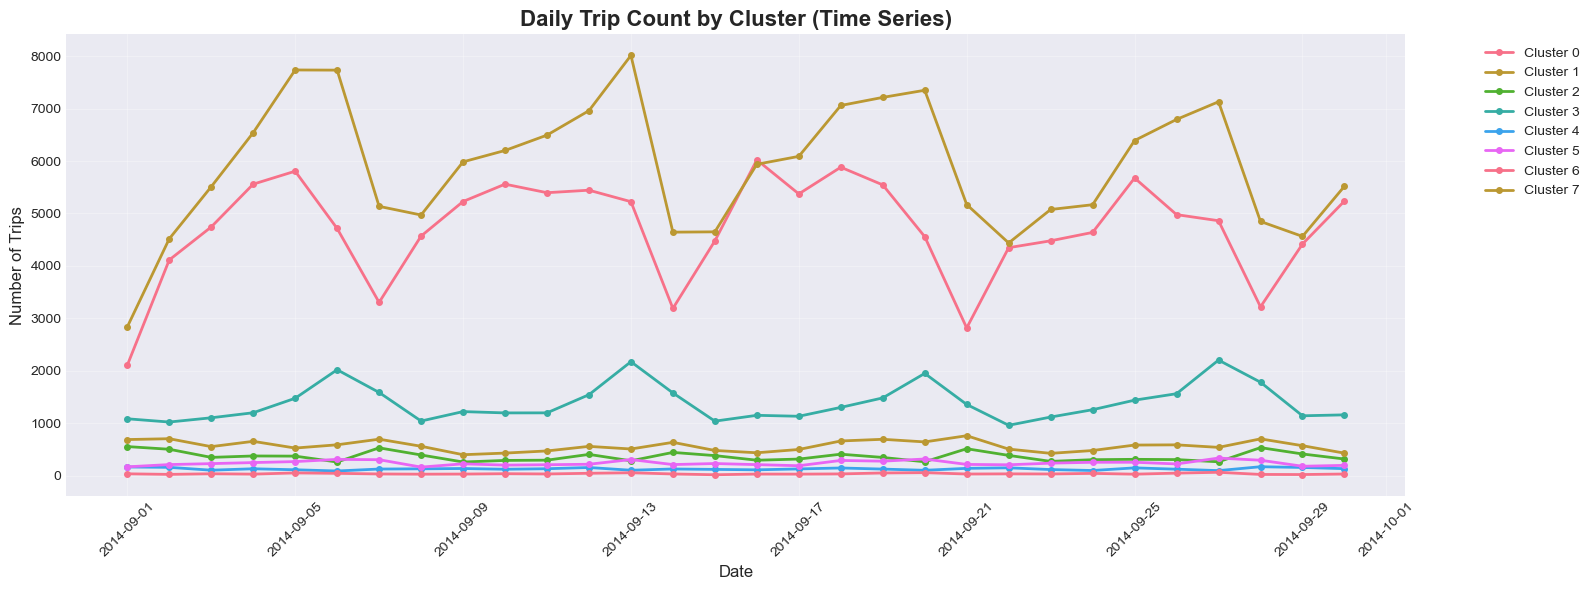

In [166]:

daily_trends = df_sample.groupby(['Date', 'KMeans_Cluster']).size().reset_index(name='Count')


fig, ax = plt.subplots(figsize=(16, 6))
for cluster in sorted(df_sample['KMeans_Cluster'].unique()):
    cluster_data = daily_trends[daily_trends['KMeans_Cluster'] == cluster]
    ax.plot(cluster_data['Date'], cluster_data['Count'], marker='o', 
            label=f'Cluster {cluster}', linewidth=2, markersize=4)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Trips', fontsize=12)
ax.set_title('Daily Trip Count by Cluster (Time Series)', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()